In [1]:
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import string
from nltk.corpus import stopwords
import math
from operator import itemgetter
from collections import Counter
from ast import literal_eval

import matplotlib.pyplot as plt
import powerlaw as pl
import seaborn as sns
import matplotlib.ticker as ticker

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# load preprocessed data
path = "E:\\PycharmProject\\ada_project\\data\\"
data = pd.read_csv(path + 'processed-quotes-2019.csv')
data.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,domains,nationality,gender,party,id
0,2019-04-08-048753,It is immoral. It is harmful. It is hurtful.,Donald Trump,Q22686,2019-04-08 16:22:00,44,"['mercedsunstar', 'sacbee', 'mynorthwest', 'la...",United States of America,male,Republican Party,Q22686
1,2019-05-15-053302,It is important for our equine science student...,Sally Johnson,Q42336656,2019-05-15 18:03:22,1,['lanereport'],United States of America,female,NaN,Q42336656
2,2019-02-27-055406,It is important to many Native American tribes...,Rafael Ortega,Q16672061,2019-02-27 00:00:00,1,['kstp'],Mexico,male,NaN,Q16672061
3,2019-12-08-023053,"It is impossible, biologically, truly to `rest...",Barry Lopez,Q809063,2019-12-08 06:00:00,1,['timescolonist'],United States of America,male,NaN,Q809063
4,2019-02-21-000088,Chilton put it on a little tape recorder and...,Sam the Sham,Q1971786,2019-02-21 11:05:34,1,['nashvillescene'],United States of America,male,NaN,Q1971786


# 1. Analysis for heavy-tailed distributions
In the first step, we try to analyze the heavy-tailed distributions in the Quotebanks. To be specific,we visualized the distribution of speakers' **occurrence**, **nationality**, **gender**, and **party**. Besides, we also drew the distribution of domains in URLs to study popularity of different media.

In [54]:
def plot_power_law(freq_data, title=None):
    # detect whether the distribution is heavy-tailed
    freq_data = freq_data.values.squeeze()
    np.seterr(divide='ignore', invalid='ignore')
    sns.set(style="ticks", font_scale=1.2)
    fig, ax = plt.subplots() 
    plt.grid()
    pl.plot_pdf(freq_data, ax=ax, linewidth=2)

    ax.set_xlim(ax.get_xlim())
    fit = pl.Fit(freq_data, discrete=True)
    fit.power_law.plot_pdf(ax=ax, linestyle='--', color=(118 / 255, 204 / 255, 95 / 255))

    ax.set_xlabel('# of occurance')
    ax.set_ylabel('Probability')
    ax.set(title=title)

    plt.draw()
    plt.show()

Calculating best minimal value for power law fit


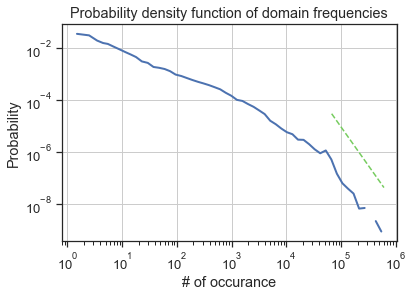

msn                607108
gamereactor        403044
einnews            391798
breitbart          299911
businessinsider    266101
nbcsports          256246
indiatimes         239688
washingtontimes    217399
pulse              203073
espn               196712
sfgate             184921
seattletimes       182965
krmg               182687
stuff              181622
wokv               179959
newsok             174413
news965            154416
smh                152831
nytimes            152662
foxnews            148476
dtype: int64

In [55]:
# transfer domains from str tolist
data['domains'] = data['domains'].apply(literal_eval)

# combine all domains into a single list
domain_counter = []
for domain in tqdm(data['domains']):
    domain_counter += domain
# calculate the frequencies of each domain
domain_counter = pd.Series(domain_counter)
domain_freq = domain_counter.value_counts()
plot_power_law(domain_freq, title='Probability density function of domain frequencies')

domain_freq[:20]

Calculating best minimal value for power law fit


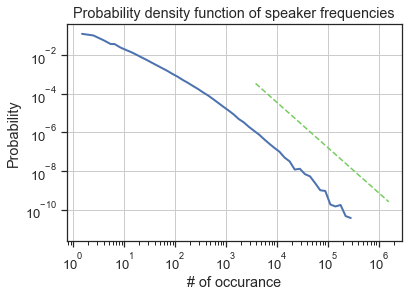

,numOccurrences
speaker,
Donald Trump,1590083
Boris Johnson,281217
Sam Bishop,211565
Nancy Pelosi,196426
Joe Biden,184776
Jeremy Corbyn,179218
Narendra Modi,147975
Mike Pompeo,140742
Elizabeth Warren,105158


In [56]:
# the distribution among speakers
speaker_data = data.groupby('speaker')
speaker_freq = speaker_data.agg({'numOccurrences': 'sum'}).sort_values(by='numOccurrences', 
                                                                                 ascending=False)
plot_power_law(speaker_freq, title='Probability density function of speaker frequencies')
speaker_freq[:20]

Calculating best minimal value for power law fit


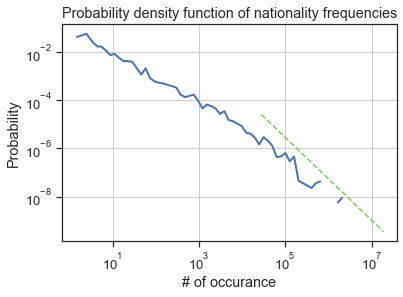

,numOccurrences
nationality,
United States of America,18800445
United Kingdom,7094027
Australia,2171030
Canada,1942274
India,1719119
Germany,643428
Ireland,600879
New Zealand,599336
France,552971


In [57]:
# the distribution among nationalities
nationality_data = data.groupby('nationality')
nationality_freq = nationality_data.agg({'numOccurrences': 'sum'}).sort_values(by='numOccurrences', 
                                                                                 ascending=False)
plot_power_law(nationality_freq, title='Probability density function of nationality frequencies')
nationality_freq[:20]

Calculating best minimal value for power law fit


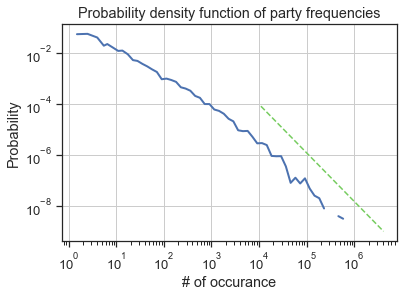

,numOccurrences
party,
Republican Party,4125069
Democratic Party,3489362
Conservative Party,1286998
Labour Party,613070
Bharatiya Janata Party,420254
Indian National Congress,258340
Liberal Party of Canada,204356
Scottish National Party,193377
Australian Labor Party,152647


In [59]:
# the distribution among parties
party_data = data.groupby('party')
party_freq = party_data.agg({'numOccurrences': 'sum'}).sort_values(by='numOccurrences', 
                                                                                 ascending=False)
plot_power_law(party_freq, title='Probability density function of party frequencies')
party_freq[:20]

In [60]:
# Number of occurrences in genders
gender_data = data.groupby('gender')
gender_freq = gender_data.agg({'numOccurrences': 'sum'}).sort_values(by='numOccurrences', 
                                                                                 ascending=False)
gender_freq[:5]

,numOccurrences
gender,
male,37071284
female,8673815
transgender female,27211
genderfluid,22648
non-binary,19170


As we can see, distributions of speakers occurrence, nationality, gender, and party are all heavy-tailed. 
This reflects the wide variety of data imbalances in the dataset. 

# 2. Visualize the domain quotation bias
In this section, we selected four famous news publisher:**New York Times**,**CNN**, **Foxnews** ,and **News Max**, to study their perference on speakers. We chose the top $10$ most quoted speakers in each domain. 

,nationality,gender,party,domain_counts
speaker,,,,
Donald Trump,United States of America,male,Republican Party,6677
Elizabeth Warren,United States of America,female,Democratic Party,1029
Joe Biden,United States of America,male,Democratic Party,1004
Nancy Pelosi,United States of America,female,Democratic Party,826
Bernie Sanders,United States of America,male,Liberty Union Party,712
Pete Buttigieg,United States of America,male,Democratic Party,681
Mike Pompeo,United States of America,male,Republican Party,552
Bill de Blasio,United States of America,male,Democratic Party,394
Cory Booker,United States of America,male,Democratic Party,391


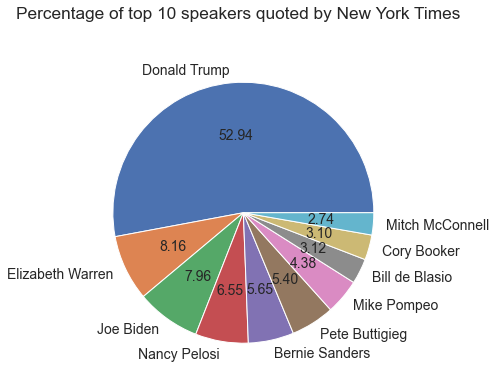

In [64]:
def select_domain_topk_freq_speaker(data, domain, topk=None):
    data['domain_counts'] = data['domains'].apply(lambda x: x.count(domain))
    domain_data = data[data['domain_counts'] > 0]
    speaker_domain_data = domain_data.groupby('speaker')
    # sort the data by domain_counts
    speaker_freq = speaker_domain_data.agg({'domain_counts': 'sum'}).sort_values(by='domain_counts', 
                                                                                 ascending=False)
    data.drop(['domain_counts'], axis=1, inplace=True)
    if topk is not None:
        return speaker_freq[:topk]
    else:
        return speaker_freq

def search_speaker_info(data, speakers):
    # filter the duplicate speakers
    tmp = data.drop_duplicates('speaker')
    tmp = tmp.set_index('speaker')
    tmp = tmp.loc[speakers.index]
    tmp = pd.concat([tmp, speakers], axis=1)
    return tmp[['nationality', 'gender', 'party', 'domain_counts']]

# Top 10 speakers in NYTimes
nytimes_top_speakers = select_domain_topk_freq_speaker(data, 'nytimes', topk=10)
nytimes_top_speakers.plot.pie(subplots=True, figsize=(6, 6), autopct='%.2f', legend=False, ylabel='',
                             fontsize=14, title='Percentage of top 10 speakers quoted by New York Times')
search_speaker_info(data, nytimes_top_speakers)

,nationality,gender,party,domain_counts
speaker,,,,
Donald Trump,United States of America,male,Republican Party,8847
Joe Biden,United States of America,male,Democratic Party,1796
Pete Buttigieg,United States of America,male,Democratic Party,1294
Elizabeth Warren,United States of America,female,Democratic Party,1290
Nancy Pelosi,United States of America,female,Democratic Party,1259
Bernie Sanders,United States of America,male,Liberty Union Party,1034
Mike Pompeo,United States of America,male,Republican Party,927
Kamala Harris,United States of America,female,Democratic Party,728
Cory Booker,United States of America,male,Democratic Party,668


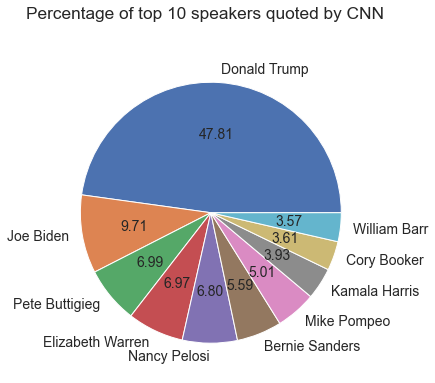

In [65]:
# Top 10 speakers in CNN
cnn_top_speakers = select_domain_topk_freq_speaker(data, 'cnn', topk=10)
cnn_top_speakers.plot.pie(subplots=True, figsize=(6, 6), autopct='%.2f', legend=False, ylabel='',
                             fontsize=14, title='Percentage of top 10 speakers quoted by CNN')
search_speaker_info(data, cnn_top_speakers)

,nationality,gender,party,domain_counts
speaker,,,,
Donald Trump,United States of America,male,Republican Party,9001
Joe Biden,United States of America,male,Democratic Party,2169
Nancy Pelosi,United States of America,female,Democratic Party,1757
Alexandria Ocasio-Cortez,United States of America,female,Democratic Party,1495
Bernie Sanders,United States of America,male,Liberty Union Party,1415
Elizabeth Warren,United States of America,female,Democratic Party,1074
Pete Buttigieg,United States of America,male,Democratic Party,862
Lindsey Graham,United States of America,male,Republican Party,816
William Barr,NaN,male,NaN,811


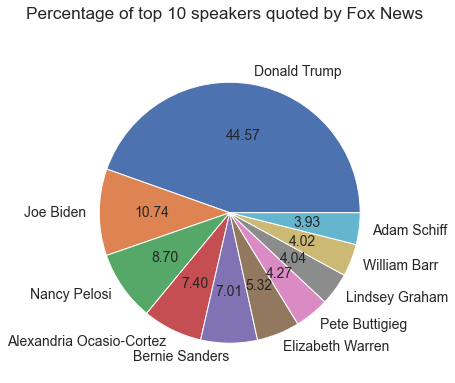

In [67]:
# Top 10 speakers in FoxNews
foxnews_top_speakers = select_domain_topk_freq_speaker(data, 'foxnews', topk=10)
foxnews_top_speakers.plot.pie(subplots=True, figsize=(6, 6), autopct='%.2f', legend=False, ylabel='',
                             fontsize=14, title='Percentage of top 10 speakers quoted by Fox News')
search_speaker_info(data, foxnews_top_speakers)

,nationality,gender,party,domain_counts
speaker,,,,
Donald Trump,United States of America,male,Republican Party,6071
Mike Pompeo,United States of America,male,Republican Party,739
Nancy Pelosi,United States of America,female,Democratic Party,733
Joe Biden,United States of America,male,Democratic Party,676
Lindsey Graham,United States of America,male,Republican Party,590
Larry Kudlow,United States of America,male,Republican Party,584
Newt Gingrich,United States of America,male,Republican Party,513
Bernie Sanders,United States of America,male,Liberty Union Party,509
Alan Dershowitz,United States of America,male,Democratic Party,485


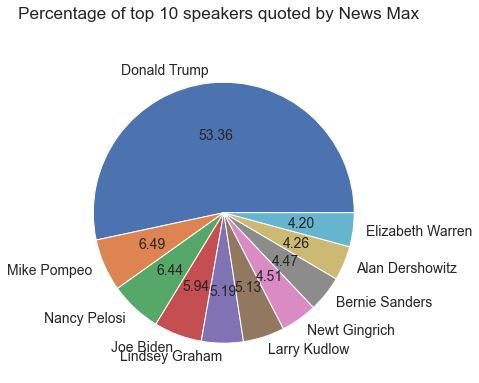

In [66]:
# Top 10 speakers in Newsmax
newsmax_top_speakers = select_domain_topk_freq_speaker(data, 'newsmax', topk=10)
newsmax_top_speakers.plot.pie(subplots=True, figsize=(6, 6), autopct='%.2f', legend=False, ylabel='',
                             fontsize=14, title='Percentage of top 10 speakers quoted by News Max')
search_speaker_info(data, newsmax_top_speakers)

Donald Trump dominates the top ten most quoted speakers(around half of the top 10 quotations). Besides, around 4/5 of speakers are male, which might reflect the gender inequality lies in media: males' sound is much louder than females. Moreover, the proportion of speakers' parties also reveals the bias: the *DNC* speakers are more likely to be explored by readers than *GOP*(except Trump).

In [16]:
# In this part, we tried to compare the difference of preference between four publishers of quoted people .

# we unioned the top 10 most quoted people from four domains, 
# and visualized the heatmap to display the discrepency among them.
indices = set(nytimes_top_speakers.index) | set(cnn_top_speakers.index) | set(foxnews_top_speakers.index) | set(newsmax_top_speakers.index)
nytimes_speakers = select_domain_topk_freq_speaker(data, 'nytimes').loc[indices]
cnn_speakers = select_domain_topk_freq_speaker(data, 'cnn').loc[indices]
foxnews_speakers = select_domain_topk_freq_speaker(data, 'foxnews').loc[indices]
newsmax_speakers = select_domain_topk_freq_speaker(data, 'newsmax').loc[indices]
# concatenate the separate data
heatmap_data = pd.concat([nytimes_speakers, cnn_speakers, foxnews_speakers, newsmax_speakers], axis=1)
heatmap_data.columns = ['nytimes', 'cnn', 'foxnews', 'newsmax']
heatmap_data

,nytimes,cnn,foxnews,newsmax
speaker,,,,
Lindsey Graham,248,541,816,590
William Barr,271,661,811,292
Pete Buttigieg,681,1294,862,273
Bernie Sanders,712,1034,1415,509
Alexandria Ocasio-Cortez,235,420,1495,352
Mike Pompeo,552,927,616,739
Donald Trump,6677,8847,9001,6071
Joe Biden,1004,1796,2169,676
Alan Dershowitz,16,7,171,485


<AxesSubplot:ylabel='speaker'>

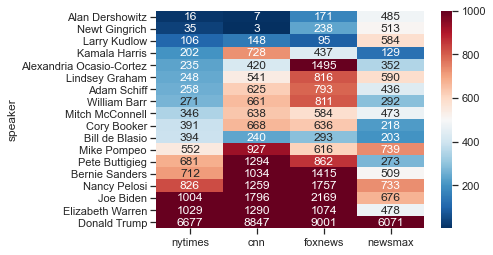

In [83]:
# Plot the heatmap
sns.set(style="ticks", font_scale=1)
heatmap_data.sort_values(by='nytimes', inplace=True)
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="RdBu_r", vmax=1000)

From the heatmap we can observe that: 
+ 1.In general, for the most famous people(e.g, Trump, Warren, and Biden), media's preference are largely accord with each other.
+ 2.But for those less popular people, media have different interest in citing what they said.

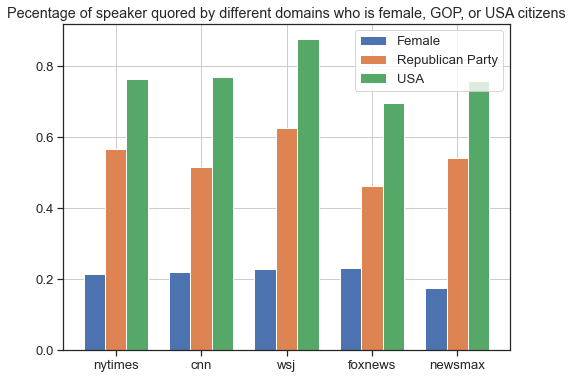

In [79]:
# In this part, we probe the percentage of speakers' gender(whether it is female), 
# party(whether it is GOP), and nationality(whether it is USA citizen) in different publishers
domains_set = ['nytimes', 'cnn', 'wsj', 'foxnews', 'newsmax']
gender_percentage = []
party_percentage = []
nationality_percentage = []

# for each publisher
for domain in domains_set:
    domain_data = data[data['domains'].apply(lambda x: domain in x)]
    
    # female
    domain_gender_data = domain_data.groupby('gender')
    domain_gender_freq = domain_gender_data.agg({'numOccurrences': 'sum'}).sort_values(by='numOccurrences', 
                                                                                 ascending=False)
    gender_per = domain_gender_freq.loc['female'] / domain_gender_freq[:2].sum()
    gender_percentage.append(gender_per[0])
    
    # Republican Party
    domain_party_data = domain_data.groupby('party')
    domain_party_freq = domain_party_data.agg({'numOccurrences': 'sum'}).sort_values(by='numOccurrences', 
                                                                                 ascending=False)
    party_per = domain_party_freq.loc['Republican Party'] / domain_party_freq.sum()
    party_percentage.append(party_per[0])
    
    # USA
    domain_nationality_data = domain_data.groupby('nationality')
    domain_nationality_freq = domain_nationality_data.agg({'numOccurrences': 'sum'}).sort_values(by='numOccurrences', 
                                                                                 ascending=False)
    nationality_per = domain_nationality_freq.loc['United States of America'] / domain_nationality_freq.sum()
    nationality_percentage.append(nationality_per[0])
plt.figure(figsize=(8, 6))
x=np.arange(len(domains_set))
bar_width=0.25   

plt.bar(x, gender_percentage, bar_width, label='Female')
plt.bar(x+bar_width, party_percentage, bar_width, label='Republican Party')
plt.bar(x+bar_width*2, nationality_percentage, bar_width, label='USA')

plt.title('Pecentage of speaker quored by different domains who is female, GOP, or USA citizens')
plt.grid(linestyle='-')
plt.legend()
plt.xticks(x+bar_width, domains_set)
plt.show()

Next, we going to study the difference of media's perference for a specific topic. It is not easy to define the topics by just observing at a single word. In order to make searching topics plausible, we choose one classical method: $\textbf{TF-IDF(Term Frequency-Inverse Document Frequency)}$. We can use the package in $\textit{sklearn}$ which can help us finish the TF-IDF task efficiently.

In [20]:
# all quotation sentences.
original_documents = data['quotation'].values
# Retrieval model
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 1, stop_words = 'english')
features = tf.fit_transform(original_documents)

# Return all document ids that that have cosine similarity with the query larger than a threshold
def search_vec_sklearn(query, features, threshold=0.1):
    new_features = tf.transform([query])
    cosine_similarities = linear_kernel(new_features, features).flatten()
    related_docs_indices, cos_sim_sorted = zip(*sorted(enumerate(cosine_similarities), key=itemgetter(1), 
                                                       reverse=True))
    doc_ids = []
    for i, cos_sim in enumerate(cos_sim_sorted):
        if cos_sim < threshold:
            break
        doc_ids.append(related_docs_indices[i])
    return doc_ids

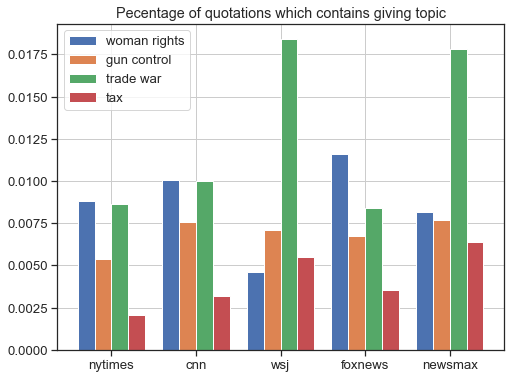

In [80]:
# Here we want to explore the percentage of some topics in different publishers
# The topics we are interested
topics = ['woman rights', 'gun control', 'trade war', 'tax']
all_percents = []
for topic in tqdm(topics):
    # get the result
    ret_ids = search_vec_sklearn(topic, features)
    topic_data = data.iloc[ret_ids]
    percents = []
    
    for domain in domains_set:
        domain_data = data[data['domains'].apply(lambda x: domain in x)]
        topic_domain_data = topic_data[topic_data['domains'].apply(lambda x: domain in x)]
        percents.append(len(topic_domain_data) / len(domain_data))
    all_percents.append(percents)
    
x=np.arange(len(domains_set))
bar_width=0.2
plt.figure(figsize=(8, 6))
for i, percents in enumerate(all_percents):
    plt.bar(x+bar_width*i, percents, bar_width, label=topics[i])

plt.title('Pecentage of quotations which contains giving topic')
plt.grid(linestyle='-')
plt.legend()
plt.xticks(x+bar_width*1.5, domains_set)
plt.show()

From the image above, we can observe that $\textit{trade war}$ occupies a larger part in $\textbf{wsj}$ and $\textbf{newsmax}$ than other publishers. The proportion of this topic, $\textit{tax}$, is the lowest in $\textbf{nytimes}$.

In conclusion, speakers' attributes displayed in different media indeed have variances to some degree. Furthermore, media's interests reflected from speakers for some topics, have much greater variances.

In [90]:
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def reduce_dim_pca(origin_m, k):
    # reduce the matrix of high dimensions by PCA to k dims
    pca = PCA(n_components=k)
    new_m = pca.fit_transform(origin_m)
    
    return new_m

def reduce_dim_tsne(origin_m, k):
    # reduce the matrix of high dimensions by TSNE to k dims
    tsne = TSNE(n_components=k, perplexity=10, learning_rate=600)
    new_m = tsne.fit_transform(origin_m)
    
    return new_m

def quotation_embedding(data):
    quo_k = np.array(data['quotation'])
    # feature matrix
    k_matrix = np.zeros([quo_k.shape[0], 768])
        
    for i in range(quo_k.shape[0]):
        tmp = '[CLS]'+ quo_k[i][:512]+'[SEP]'
        tokenized_text = tokenizer.tokenize(tmp)
        indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
        segments_ids = [1] * len(tokenized_text)
    
        # Convert inputs to PyTorch tensors
        tokens_tensor = torch.tensor([indexed_tokens])
        segments_tensors = torch.tensor([segments_ids])

        # Put the model in "evaluation" mode, meaning feed-forward operation.
        model.eval()
        with torch.no_grad():
            encoded_layers, _ = model(tokens_tensor, segments_tensors)
        # obtain the sentence embedding
        sentence_embedding = (torch.mean(encoded_layers[11], 1))
    
        k_matrix[i] = np.array(sentence_embedding)
    return k_matrix.mean(axis=0)

# 3. Quotation Visualization
In addition to studying the attributes of the quoted speakers, what they say is also important to show their discrepency. Therefore, we implemented visualization of sentences to study the variability among speakers.

Below we used a simple example about the difference between **GOP** and **DNC** about the topic of *gun control* to varify our methods. Specifically, we first use $\textbf{Bert pretrained embedding}$ to obtain the embedding of a quotation. Then we tried two different dimension reduction methods: **PCA** and **T-SNE**, to compress the sentence embedding into 2D. Finally, we visualized the embedding to show their discrepencies.

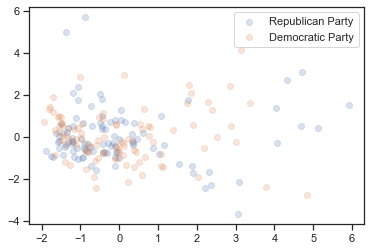

In [88]:
# Different parties' attitude to a giving topic
ret_ids = search_vec_sklearn('gun control', features)
sub_group_data = data.iloc[ret_ids]

# Republican Party quotations
rep_sub_group_data = sub_group_data[sub_group_data.party == 'Republican Party']
# Democratic Party quotations
dem_sub_group_data = sub_group_data[sub_group_data.party == 'Democratic Party']

# Embedding
# Republican party
rep_sub_group_quote_speakers = rep_sub_group_quote_data['speaker'].unique()
# choose quotations randomly
rep_sub_group_quote_speakers = np.random.choice(rep_sub_group_quote_speakers, 100, replace=False)
rep_sub_group_embeddings = np.zeros([len(rep_sub_group_quote_speakers), 768])
for i, quote_speaker in enumerate(tqdm(rep_sub_group_quote_speakers)): 
    rep_sub_group_embeddings[i] = quotation_embedding(rep_sub_group_data[rep_sub_group_data['speaker']==quote_speaker])

# Democratic party
dem_sub_group_quote_speakers = dem_sub_group_quote_data['speaker'].unique()
dem_sub_group_quote_speakers = np.random.choice(dem_sub_group_quote_speakers, 100, replace=False)
dem_sub_group_embeddings =  np.zeros([len(dem_sub_group_quote_speakers), 768])
for i, quote_speaker in enumerate(tqdm(dem_sub_group_quote_speakers)): 
    dem_sub_group_embeddings[i] = quotation_embedding(dem_sub_group_data[dem_sub_group_data['speaker']==quote_speaker])

# PCA
rep_embeddings = reduce_dim_pca(rep_sub_group_embeddings, k=2)
dem_embeddings = reduce_dim_pca(dem_sub_group_embeddings, k=2)

# plot
plt.scatter(x=rep_embeddings[:, 0], y=rep_embeddings[:, 1], alpha=0.2, label='Republican Party')
plt.scatter(x=dem_embeddings[:, 0], y=dem_embeddings[:, 1], alpha=0.2, label='Democratic Party')
plt.legend()

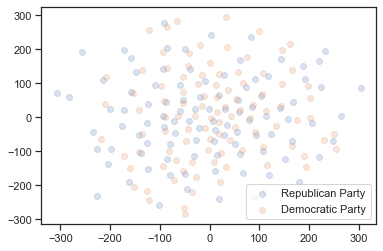

In [91]:
# T-SNE
rep_covid_m = reduce_dim_tsne(rep_sub_group_embeddings, k = 2)
dem_covid_m = reduce_dim_tsne(dem_sub_group_embeddings, k = 2)

# plot
plt.scatter(x = rep_covid_m[:,0], y = rep_covid_m[:,1], alpha = 0.2, label = 'Republican Party')
plt.scatter(x = dem_covid_m[:,0], y = dem_covid_m[:,1], alpha = 0.2, label = 'Democratic Party')
plt.legend()

The results of the visualization didn't seem to be particularly obvious at the moment and needed to be further improved.

# 4. Time series in QuoteBank

Apart from what we discussed before, we should also notice that date is also an important variable we can use. When we combine another variable with date, we can find the potential trend pattern inside our data. In other words, we can observe how this variable changes over time.

Therefore, in the function *gender_bias_time_series* below, we tried to visualize the evolution of female percentage of a topic. 

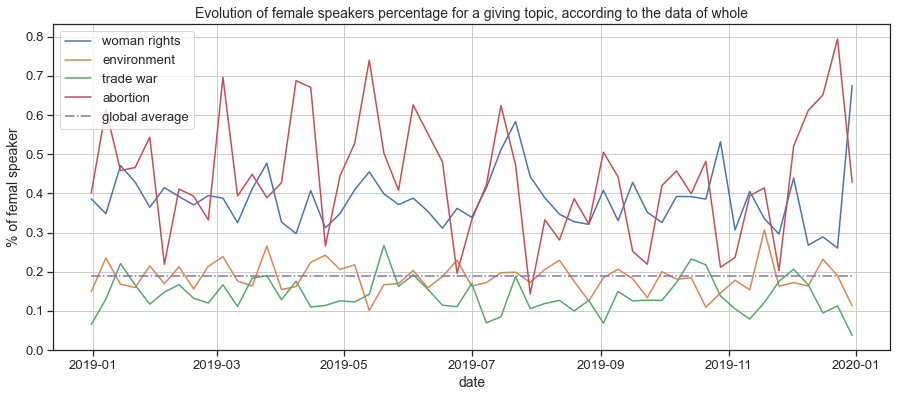

In [82]:
def gender_bias_time_series(data, topics=None, publisher='whole'):
    '''
    Input:
    data: QuoteBank data.
    topics: topics that you are interested at, such as 'COVID', 'health' and so on.
    publisher: Here you can input the names of publishers(i.e. domains), for example, 'cnn',
               'nytimes',.... Then you can get the data from that publisher; 
               If you want data from all publishers, you should input 'whole'
    '''
    # features are defined and got before
    fig, ax = plt.subplots(1,1, figsize = (15,6))
    for topic in topics:
        ids = search_vec_sklearn(topic, features)
        # map to original data
        mapped_data = data.iloc[ids]
        # mapped_data = data
        if publisher != 'whole':
            mapped_data = mapped_data[mapped_data.domains.apply(lambda x: publisher in x)]

        # sort by date
        mapped_data = mapped_data.sort_values(by='date')
        # parse to datetime
        mapped_data['date'] = pd.to_datetime(mapped_data['date'], format = ('%Y-%m-%d'))
        mapped_data['date'] = mapped_data['date']-pd.to_timedelta(7, unit='d')

        # male
        male_data = mapped_data[mapped_data.gender == 'male']
        male_occu = male_data.groupby([pd.Grouper(key = 'date', freq='W-MON')]).agg({'numOccurrences':'sum'})
        # female
        feml_date = mapped_data[mapped_data.gender == 'female']
        feml_occu = feml_date.groupby([pd.Grouper(key = 'date', freq='W-MON')]).agg({'numOccurrences':'sum'})
        
        percentage = feml_occu / (feml_occu + male_occu)
        # print(percentage)
        # percentages.append(percentage)
        plt.plot(percentage, label=topic)
    gender_data = data.groupby('gender')
    gender_freq = gender_data.agg({'numOccurrences': 'sum'}).sort_values(by='numOccurrences', 
                                                                                 ascending=False)
    global_average = gender_freq.loc['female'] / (gender_freq.loc['female'] + gender_freq.loc['male'])
    global_average = pd.Series([global_average[0]] * len(percentage), index=percentage.index)
    plt.plot(global_average, label='global average', linestyle='dashdot')    
    plt.grid(linestyle='-')
    plt.xlabel('date', fontsize=14)
    plt.ylabel('% of femal speaker', fontsize=14)
    plt.legend()
    plt.title("Evolution of female speakers percentage for a giving topic, according to the data of "+publisher, fontsize=14)
gender_bias_time_series(data, 
                        topics=['woman rights', 'environment', 'trade war', 'abortion'], 
                        publisher='whole')

We can see that the percentage of women in some topics(such as **women's rights** and **abortion**) are much higher than other topics, but the values are still below $0.5$. In addition, in 2019, the percentage of female speakers was relatively consistent overall, though there were some fluctuations. We will extend this time period in the future to draw more reasonable conclusions.